## Imports

In [1]:
import collections
import gymnasium as gym
import itertools
import numpy as np
from numpy.typing import NDArray
import pandas as pd
import random
import time
import torch
from torch.optim.lr_scheduler import _LRScheduler
from typing import List, Tuple, Deque, Optional, Callable
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

from GolfField import GolfField, Point, Ball
from GolfEnv import GolfEnv, GolfEnv8d1p
from utils import QNetwork, MinimumExponentialLR, EpsilonGreedy, ReplayBuffer, \
                  train_dqn2_agent, get_episode_len, train_dqn1_agent, train_naive_agent, \
                  train_reinforce_discrete, sample_one_episode, train_a2c_discrete, sample_one_episode_value

%load_ext autoreload
%autoreload 2

In [2]:
def get_episode_len_fix(env, q_network, epsilon_greedy, device='cpu'):
    state, info = env.reset()
    episode_len = 0

    for t in itertools.count():
        state_tensor = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
        action_dist = q_network(state_tensor).squeeze()
        action = epsilon_greedy(state)

        state, reward, done, truncated, _ = env.step(action)
        if done:
            break
        episode_len += 1

    return episode_len

## Environment

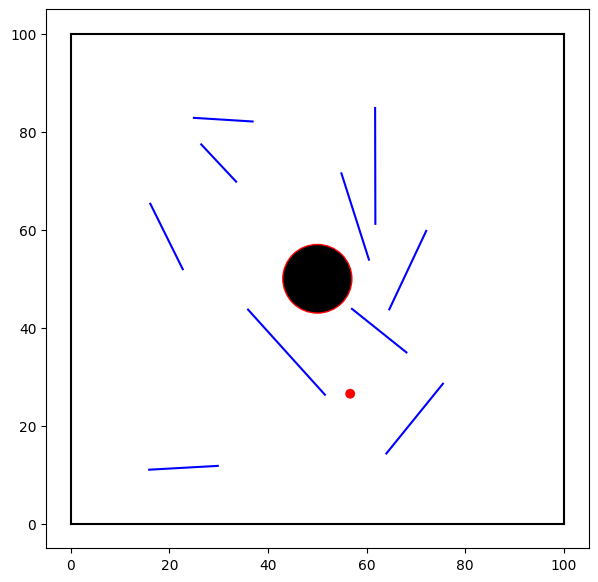

In [3]:
env = GolfEnv8d1p(0, 10, lambda old_dist, new_dist: ((new_dist < old_dist) * 2 - 1) * 100)
env.field.hole = Ball(Point(50, 50), 7)
env.field.hole_R = 7
env.reset()
env.render()

## Naive DQN

In [37]:
device = 'cpu'
NUMBER_OF_TRAININGS = 3
naive_trains_result_list = [[], [], []]

for train_index in range(NUMBER_OF_TRAININGS):
    q_network = QNetwork(2, 8, nn_l1=128, nn_l2=128).to(device)
    optimizer = torch.optim.AdamW(q_network.parameters(), lr=0.004, amsgrad=True)
    lr_scheduler = MinimumExponentialLR(optimizer, lr_decay=0.97, min_lr=0.0001)
    loss_fn = torch.nn.MSELoss()

    epsilon_greedy = EpsilonGreedy(epsilon_start=0.82, epsilon_min=0.013, epsilon_decay=0.9675, env=env, q_network=q_network)

    # Train the q-network

    episode_reward_list = train_naive_agent(env,
                                            q_network,
                                            optimizer,
                                            loss_fn,
                                            epsilon_greedy,
                                            device,
                                            lr_scheduler,
                                            num_episodes=2000,
                                            gamma=0.9)
    naive_trains_result_list[0].extend(range(len(episode_reward_list)))
    naive_trains_result_list[1].extend(episode_reward_list)
    naive_trains_result_list[2].extend([train_index for _ in episode_reward_list])

naive_trains_result_df = pd.DataFrame(np.array(naive_trains_result_list).T, columns=["num_episodes", "mean_final_episode_reward", "training_index"])
naive_trains_result_df["agent"] = "Naive"

# Save the action-value estimation function of the last train

torch.save(q_network, "naive_q_network.pth")

100%|██████████| 9/9 [00:06<00:00,  1.37it/s]


99


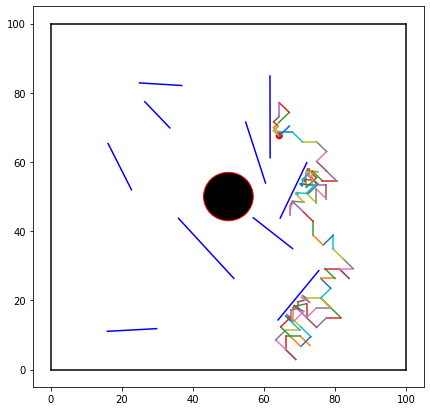

In [38]:
print(get_episode_len(env, q_network, epsilon_greedy))
env.render()

In [39]:
lens = np.array([get_episode_len_fix(env, q_network, epsilon_greedy) for i in tqdm(range(500))])
print('Mean route len:', np.mean(lens))
print('Success rate:', np.mean(lens < 99))

100%|██████████| 10/10 [00:07<00:00,  1.42it/s]

Mean route len: 99.0
Success rate: 0.0


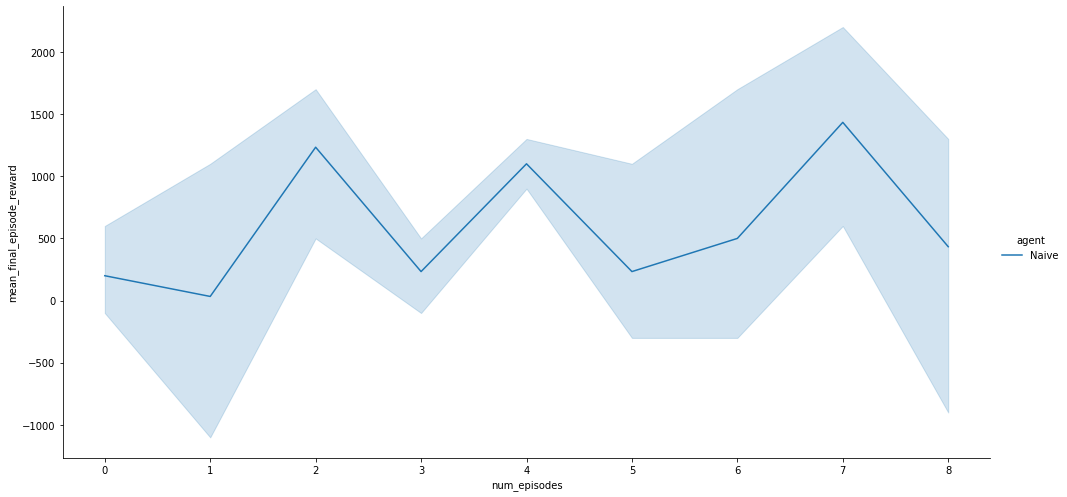

In [40]:
# g = sns.relplot(x="num_episodes", y="mean_final_episode_reward", kind="line", hue="agent", estimator=None, units="training_index", data=naive_trains_result_df,
#                 height=7, aspect=2, alpha=0.5);
g = sns.relplot(x="num_episodes", y="mean_final_episode_reward", hue="agent", kind="line", data=naive_trains_result_df, height=7, aspect=2)

## DQN with buffer

In [5]:
device = 'cpu'
NUMBER_OF_TRAININGS = 3
dqn1_trains_result_list = [[], [], []]

for train_index in range(NUMBER_OF_TRAININGS):
    q_network = QNetwork(2, 8, nn_l1=128, nn_l2=128).to(device)
    optimizer = torch.optim.AdamW(q_network.parameters(), lr=0.004, amsgrad=True)
    lr_scheduler = MinimumExponentialLR(optimizer, lr_decay=0.97, min_lr=0.0001)
    loss_fn = torch.nn.MSELoss()

    epsilon_greedy = EpsilonGreedy(epsilon_start=0.82, epsilon_min=0.013, epsilon_decay=0.9675, env=env, q_network=q_network)

    replay_buffer = ReplayBuffer(2000)

    # Train the q-network

    episode_reward_list = train_dqn1_agent(env,
                                           q_network,
                                           optimizer,
                                           loss_fn,
                                           epsilon_greedy,
                                           device,
                                           lr_scheduler,
                                           num_episodes=2000,
                                           gamma=0.9,
                                           batch_size=64,
                                           replay_buffer=replay_buffer)
    dqn1_trains_result_list[0].extend(range(len(episode_reward_list)))
    dqn1_trains_result_list[1].extend(episode_reward_list)
    dqn1_trains_result_list[2].extend([train_index for _ in episode_reward_list])

dqn1_trains_result_df = pd.DataFrame(np.array(dqn1_trains_result_list).T, columns=["num_episodes", "mean_final_episode_reward", "training_index"])
dqn1_trains_result_df["agent"] = "DQN 2013"

# Save the action-value estimation function

torch.save(q_network, "dqn1_q_network.pth")

100%|██████████| 9/9 [00:09<00:00,  1.00s/it]


[600, 500, -900, 1300, -500, 500, 900, -100, 300]


100%|██████████| 9/9 [00:10<00:00,  1.15s/it]


[-100, -100, 300, -500, -700, 100, -1900, 700, 500]


100%|██████████| 9/9 [00:09<00:00,  1.07s/it]

[900, 1100, -500, -900, 1500, 800, 400, 500, 700]


99


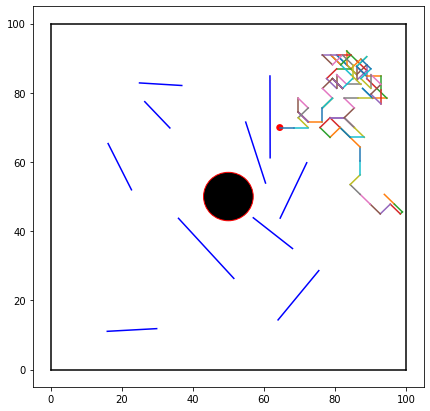

In [6]:
print(get_episode_len_fix(env, q_network, epsilon_greedy))
env.render()

In [7]:
lens = np.array([get_episode_len_fix(env, q_network, epsilon_greedy) for i in tqdm(range(500))])
print('Mean route len:', np.mean(lens))
print('Success rate:', np.mean(lens < 99))

100%|██████████| 10/10 [00:03<00:00,  2.63it/s]

Mean route len: 69.6
Success rate: 0.4


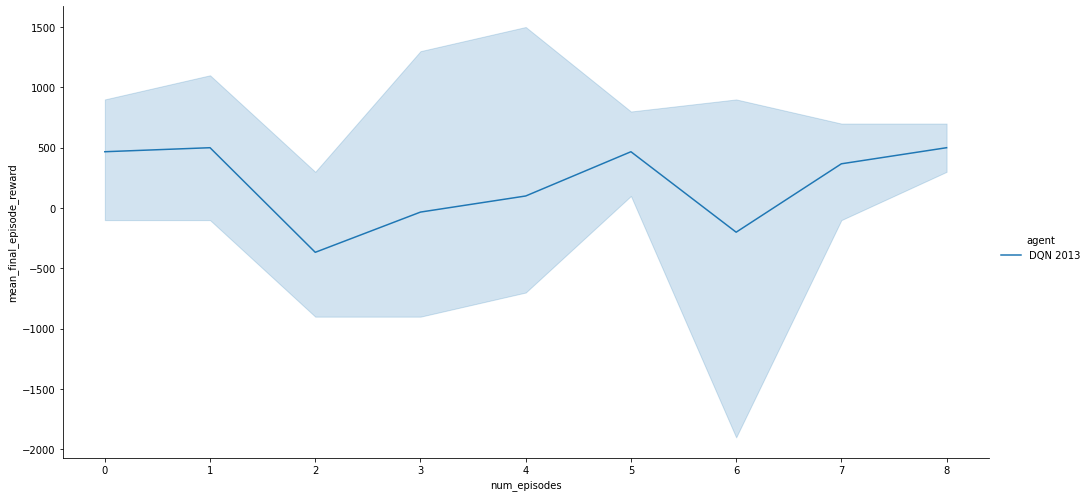

In [9]:
# g = sns.relplot(x="num_episodes", y="mean_final_episode_reward", kind="line", hue="agent", estimator=None, units="training_index", data=dqn1_trains_result_df,
#                 height=7, aspect=2, alpha=0.5);
g = sns.relplot(x="num_episodes", y="mean_final_episode_reward", hue="agent", kind="line", data=dqn1_trains_result_df, height=7, aspect=2)

## DQN with target network

In [4]:
device = 'cpu'
NUMBER_OF_TRAININGS = 3
dqn2_trains_result_list = [[], [], []]

for train_index in range(NUMBER_OF_TRAININGS):
    state_dim = 2
    action_dim = 8
    q_network = QNetwork(state_dim, action_dim, nn_l1=128, nn_l2=128).to(device)
    target_q_network = QNetwork(state_dim, action_dim, nn_l1=128, nn_l2=128).to(device)
    target_q_network.load_state_dict(q_network.state_dict())

    optimizer = torch.optim.AdamW(q_network.parameters(), lr=0.004, amsgrad=True)
    lr_scheduler = MinimumExponentialLR(optimizer, lr_decay=0.97, min_lr=0.0001)
    loss_fn = torch.nn.MSELoss()

    epsilon_greedy = EpsilonGreedy(epsilon_start=0.82, epsilon_min=0.013, epsilon_decay=0.9675, env=env, q_network=q_network)

    replay_buffer = ReplayBuffer(2000)

    # Train the q-network

    episode_reward_list = train_dqn2_agent(env,
                                           q_network,
                                           target_q_network,
                                           optimizer,
                                           loss_fn,
                                           epsilon_greedy,
                                           device,
                                           lr_scheduler,
                                           num_episodes=2000,
                                           gamma=0.9,
                                           batch_size=128,
                                           replay_buffer=replay_buffer,
                                           target_q_network_sync_period=30)
    dqn2_trains_result_list[0].extend(range(len(episode_reward_list)))
    dqn2_trains_result_list[1].extend(episode_reward_list)
    dqn2_trains_result_list[2].extend([train_index for _ in episode_reward_list])

dqn2_trains_result_df = pd.DataFrame(np.array(dqn2_trains_result_list).T, columns=["num_episodes", "mean_final_episode_reward", "training_index"])
dqn2_trains_result_df["agent"] = "DQN 2015"

# Save the action-value estimation function

torch.save(q_network, "dqn2_q_network.pth")

  3%|▎         | 53/1999 [00:05<02:37, 12.33it/s]

1030.6122448979593


  5%|▍         | 99/1999 [00:11<04:49,  6.57it/s]

1244.0


  8%|▊         | 150/1999 [00:16<02:57, 10.43it/s]

1406.0


 10%|█         | 201/1999 [00:20<02:22, 12.64it/s]

2000.0


 12%|█▏        | 249/1999 [00:24<02:09, 13.54it/s]

1998.0


 15%|█▌        | 302/1999 [00:28<01:53, 14.91it/s]

2082.0


 18%|█▊        | 351/1999 [00:34<02:18, 11.93it/s]

2100.0


 20%|█▉        | 398/1999 [00:38<02:25, 10.98it/s]

2516.0


 22%|██▏       | 449/1999 [00:41<01:29, 17.34it/s]

2056.0


 25%|██▌       | 504/1999 [00:46<01:17, 19.28it/s]

2630.0


 27%|██▋       | 549/1999 [00:50<01:22, 17.50it/s]

2358.0


 30%|███       | 604/1999 [00:55<01:41, 13.78it/s]

2848.0


 32%|███▏      | 649/1999 [00:59<02:00, 11.18it/s]

2994.0


 35%|███▌      | 701/1999 [01:03<01:10, 18.39it/s]

3020.0


 38%|███▊      | 750/1999 [01:07<01:29, 13.92it/s]

2948.0


 40%|████      | 800/1999 [01:12<01:40, 11.95it/s]

2770.0


 43%|████▎     | 851/1999 [01:16<01:35, 11.98it/s]

2930.0


 45%|████▌     | 900/1999 [01:20<01:34, 11.66it/s]

2956.0


 47%|████▋     | 949/1999 [01:24<01:24, 12.37it/s]

3246.0


 50%|█████     | 1001/1999 [01:28<01:28, 11.29it/s]

2948.0


 53%|█████▎    | 1050/1999 [01:32<01:31, 10.35it/s]

2982.0


 55%|█████▍    | 1099/1999 [01:36<01:11, 12.57it/s]

2748.0


 58%|█████▊    | 1152/1999 [01:40<00:47, 17.91it/s]

2752.0


 60%|█████▉    | 1199/1999 [01:44<01:07, 11.87it/s]

2914.0


 62%|██████▏   | 1249/1999 [01:48<01:10, 10.71it/s]

3158.0


 65%|██████▌   | 1300/1999 [01:53<01:12,  9.63it/s]

3212.0


 68%|██████▊   | 1353/1999 [01:56<00:36, 17.51it/s]

2912.0


 70%|███████   | 1400/1999 [02:00<00:44, 13.43it/s]

2634.0


 73%|███████▎  | 1451/1999 [02:04<00:43, 12.59it/s]

2890.0


 75%|███████▌  | 1501/1999 [02:09<00:34, 14.25it/s]

2880.0


 78%|███████▊  | 1551/1999 [02:13<00:43, 10.32it/s]

3074.0


 80%|███████▉  | 1599/1999 [02:17<00:39, 10.03it/s]

2782.0


 83%|████████▎ | 1653/1999 [02:21<00:21, 16.36it/s]

2946.0


 85%|████████▌ | 1703/1999 [02:25<00:21, 13.64it/s]

3304.0


 88%|████████▊ | 1752/1999 [02:28<00:10, 24.22it/s]

2834.0


 90%|█████████ | 1800/1999 [02:32<00:19, 10.43it/s]

2750.0


 92%|█████████▏| 1849/1999 [02:36<00:10, 13.94it/s]

3096.0


 95%|█████████▌| 1900/1999 [02:41<00:12,  7.89it/s]

3102.0


 98%|█████████▊| 1950/1999 [02:45<00:04, 12.09it/s]

3044.0


100%|██████████| 1999/1999 [02:49<00:00, 11.83it/s]


2888.0


  3%|▎         | 51/1999 [00:06<03:10, 10.20it/s]

1200.0


  5%|▌         | 101/1999 [00:12<02:16, 13.93it/s]

1022.0


  8%|▊         | 150/1999 [00:17<03:31,  8.76it/s]

2076.0


 10%|█         | 200/1999 [00:22<02:31, 11.89it/s]

2080.0


 13%|█▎        | 252/1999 [00:27<01:35, 18.31it/s]

2298.0


 15%|█▍        | 299/1999 [00:31<01:30, 18.80it/s]

2568.0


 17%|█▋        | 349/1999 [00:35<02:33, 10.75it/s]

2652.0


 20%|██        | 400/1999 [00:40<01:58, 13.50it/s]

3130.0


 22%|██▏       | 449/1999 [00:44<02:20, 11.03it/s]

2944.0


 25%|██▌       | 500/1999 [00:48<01:55, 12.94it/s]

2794.0


 28%|██▊       | 550/1999 [00:52<02:22, 10.18it/s]

2932.0


 30%|███       | 600/1999 [00:56<01:57, 11.88it/s]

2716.0


 33%|███▎      | 650/1999 [01:00<01:28, 15.20it/s]

2742.0


 35%|███▌      | 700/1999 [01:03<01:53, 11.43it/s]

2842.0


 37%|███▋      | 749/1999 [01:07<01:37, 12.82it/s]

2950.0


 40%|███▉      | 799/1999 [01:12<02:06,  9.45it/s]

3350.0


 42%|████▏     | 848/1999 [01:16<02:21,  8.16it/s]

3130.0


 45%|████▌     | 901/1999 [01:20<01:11, 15.41it/s]

2918.0


 48%|████▊     | 951/1999 [01:25<01:33, 11.22it/s]

3008.0


 50%|█████     | 1001/1999 [01:29<01:34, 10.54it/s]

2994.0


 53%|█████▎    | 1051/1999 [01:33<01:15, 12.62it/s]

2958.0


 55%|█████▌    | 1100/1999 [01:38<01:23, 10.81it/s]

3264.0


 58%|█████▊    | 1150/1999 [01:42<01:21, 10.42it/s]

3148.0


 60%|██████    | 1202/1999 [01:46<00:31, 25.59it/s]

3022.0


 63%|██████▎   | 1251/1999 [01:49<01:05, 11.36it/s]

2654.0


 65%|██████▌   | 1300/1999 [01:54<01:16,  9.08it/s]

2988.0


 68%|██████▊   | 1350/1999 [02:00<00:57, 11.38it/s]

3066.0


 70%|███████   | 1400/1999 [02:04<00:49, 12.06it/s]

3004.0


 72%|███████▏  | 1448/1999 [02:08<00:58,  9.44it/s]

2934.0


 75%|███████▍  | 1499/1999 [02:12<00:26, 18.89it/s]

2888.0


 78%|███████▊  | 1552/1999 [02:17<00:41, 10.73it/s]

3102.0


 80%|████████  | 1601/1999 [02:22<00:41,  9.66it/s]

3132.0


 83%|████████▎ | 1651/1999 [02:26<00:23, 14.72it/s]

3032.0


 85%|████████▌ | 1700/1999 [02:29<00:23, 12.69it/s]

3174.0


 88%|████████▊ | 1751/1999 [02:32<00:14, 16.79it/s]

2742.0


 90%|████████▉ | 1799/1999 [02:36<00:19, 10.04it/s]

3076.0


 93%|█████████▎| 1853/1999 [02:40<00:06, 21.91it/s]

2948.0


 95%|█████████▌| 1902/1999 [02:43<00:04, 22.12it/s]

2310.0


 98%|█████████▊| 1953/1999 [02:45<00:01, 27.44it/s]

2760.0


100%|██████████| 1999/1999 [02:48<00:00, 11.87it/s]


2534.0


  2%|▏         | 49/1999 [00:05<06:11,  5.24it/s]

1020.4081632653061


  5%|▌         | 101/1999 [00:11<03:10,  9.96it/s]

1888.0


  7%|▋         | 149/1999 [00:15<03:02, 10.16it/s]

2254.0


 10%|█         | 201/1999 [00:21<02:21, 12.69it/s]

1760.0


 13%|█▎        | 250/1999 [00:26<02:26, 11.90it/s]

2212.0


 15%|█▍        | 299/1999 [00:31<02:59,  9.48it/s]

2092.0


 18%|█▊        | 351/1999 [00:36<02:22, 11.58it/s]

2114.0


 20%|██        | 401/1999 [00:42<03:07,  8.53it/s]

2312.0


 23%|██▎       | 450/1999 [00:46<02:52,  9.00it/s]

2602.0


 25%|██▍       | 499/1999 [00:51<01:59, 12.51it/s]

2210.0


 28%|██▊       | 550/1999 [00:55<02:36,  9.27it/s]

3058.0


 30%|███       | 602/1999 [01:00<01:25, 16.29it/s]

2992.0


 33%|███▎      | 650/1999 [01:03<01:48, 12.38it/s]

2892.0


 35%|███▍      | 699/1999 [01:07<01:59, 10.86it/s]

3146.0


 38%|███▊      | 753/1999 [01:11<01:13, 17.05it/s]

3002.0


 40%|███▉      | 799/1999 [01:15<01:18, 15.27it/s]

2868.0


 43%|████▎     | 850/1999 [01:20<01:33, 12.33it/s]

2948.0


 45%|████▍     | 899/1999 [01:24<01:32, 11.93it/s]

3294.0


 48%|████▊     | 951/1999 [01:29<01:15, 13.95it/s]

3254.0


 50%|████▉     | 998/1999 [01:33<01:25, 11.67it/s]

2876.0


 52%|█████▏    | 1049/1999 [01:39<01:19, 11.96it/s]

3094.0


 55%|█████▌    | 1105/1999 [01:42<00:43, 20.35it/s]

3010.0


 58%|█████▊    | 1152/1999 [01:45<00:44, 19.20it/s]

2862.0


 60%|██████    | 1201/1999 [01:47<00:41, 19.07it/s]

2660.0


 63%|██████▎   | 1250/1999 [01:50<00:29, 25.42it/s]

2632.0


 65%|██████▌   | 1305/1999 [01:52<00:22, 30.24it/s]

2424.0


 67%|██████▋   | 1349/1999 [01:54<00:20, 32.00it/s]

2416.0


 70%|███████   | 1401/1999 [01:57<00:29, 20.07it/s]

2828.0


 73%|███████▎  | 1453/1999 [01:59<00:32, 16.75it/s]

2580.0


 75%|███████▌  | 1500/1999 [02:01<00:17, 27.96it/s]

2460.0


 77%|███████▋  | 1548/1999 [02:03<00:19, 23.04it/s]

2590.0


 80%|████████  | 1605/1999 [02:06<00:13, 28.73it/s]

2256.0


 83%|████████▎ | 1653/1999 [02:07<00:11, 28.98it/s]

2532.0


 85%|████████▌ | 1701/1999 [02:10<00:16, 17.62it/s]

2182.0


 88%|████████▊ | 1753/1999 [02:13<00:08, 28.50it/s]

2638.0


 90%|█████████ | 1802/1999 [02:15<00:08, 23.51it/s]

2512.0


 93%|█████████▎| 1852/1999 [02:17<00:05, 25.11it/s]

2528.0


 95%|█████████▌| 1901/1999 [02:20<00:03, 24.95it/s]

2660.0


 98%|█████████▊| 1952/1999 [02:22<00:01, 33.66it/s]

2564.0


100%|██████████| 1999/1999 [02:24<00:00, 13.86it/s]


2764.0


14


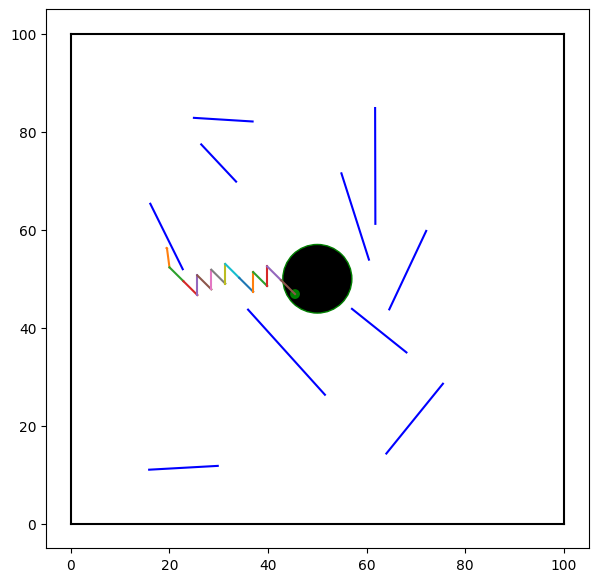

In [5]:
print(get_episode_len_fix(env, q_network, epsilon_greedy))
env.render()

In [6]:
lens = np.array([get_episode_len_fix(env, q_network, epsilon_greedy) for i in tqdm(range(500))])
print('Mean route len:', np.mean(lens))
print('Success rate:', np.mean(lens < 99))

100%|██████████| 500/500 [00:16<00:00, 30.34it/s]

Mean route len: 33.244
Success rate: 0.81


<font color=red size=5>Model success rate: <font color=green size=5>0.81</font></font>



/Users/akulyat/Desktop/EP/venvEP/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/akulyat/Desktop/EP/venvEP/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/akulyat/Desktop/EP/venvEP/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/akulyat/Desktop/EP/venvEP/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future versi

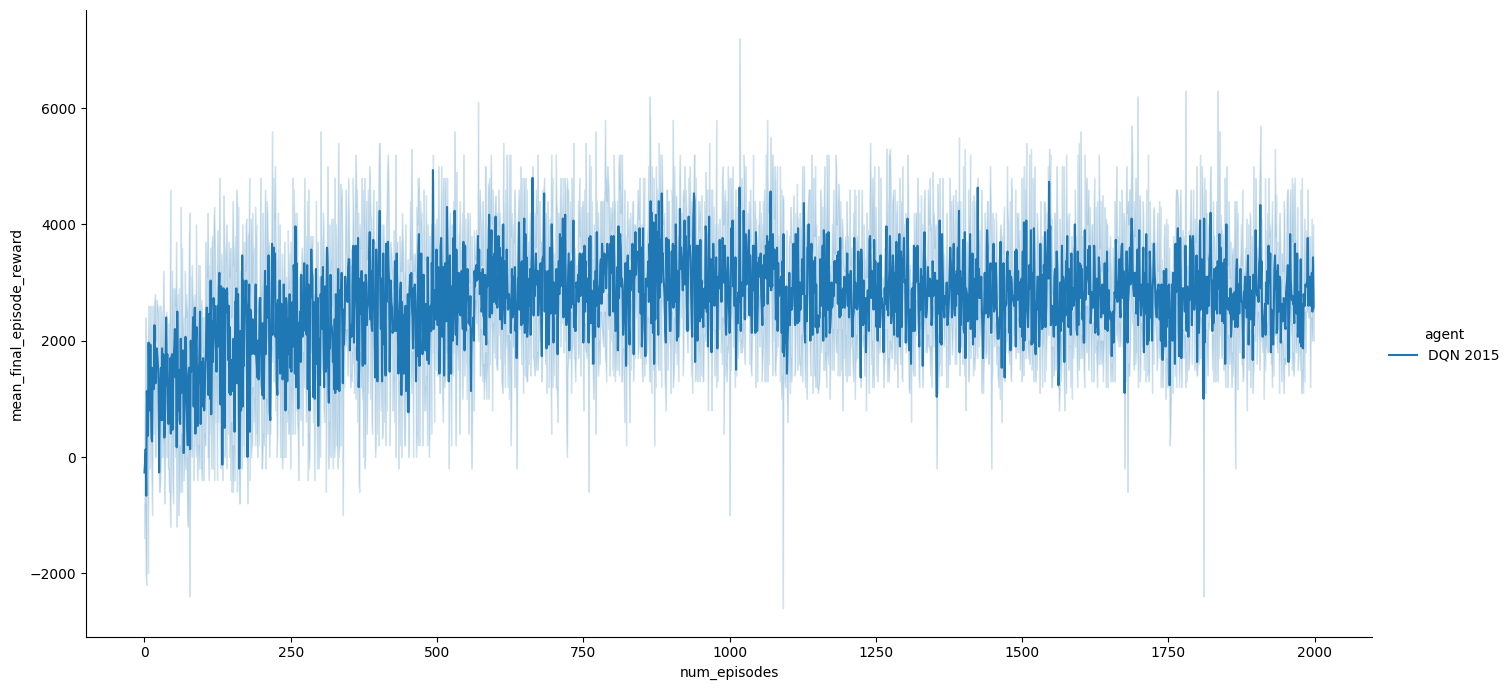

In [7]:
# g = sns.relplot(x="num_episodes", y="mean_final_episode_reward", kind="line", hue="agent", estimator=None, units="training_index", data=dqn2_trains_result_df,
#                 height=7, aspect=2, alpha=0.5);
g = sns.relplot(x="num_episodes", y="mean_final_episode_reward", hue="agent", kind="line", data=dqn2_trains_result_df, height=7, aspect=2)

23
19
8
19
29
9
3
20
19
4
27
99


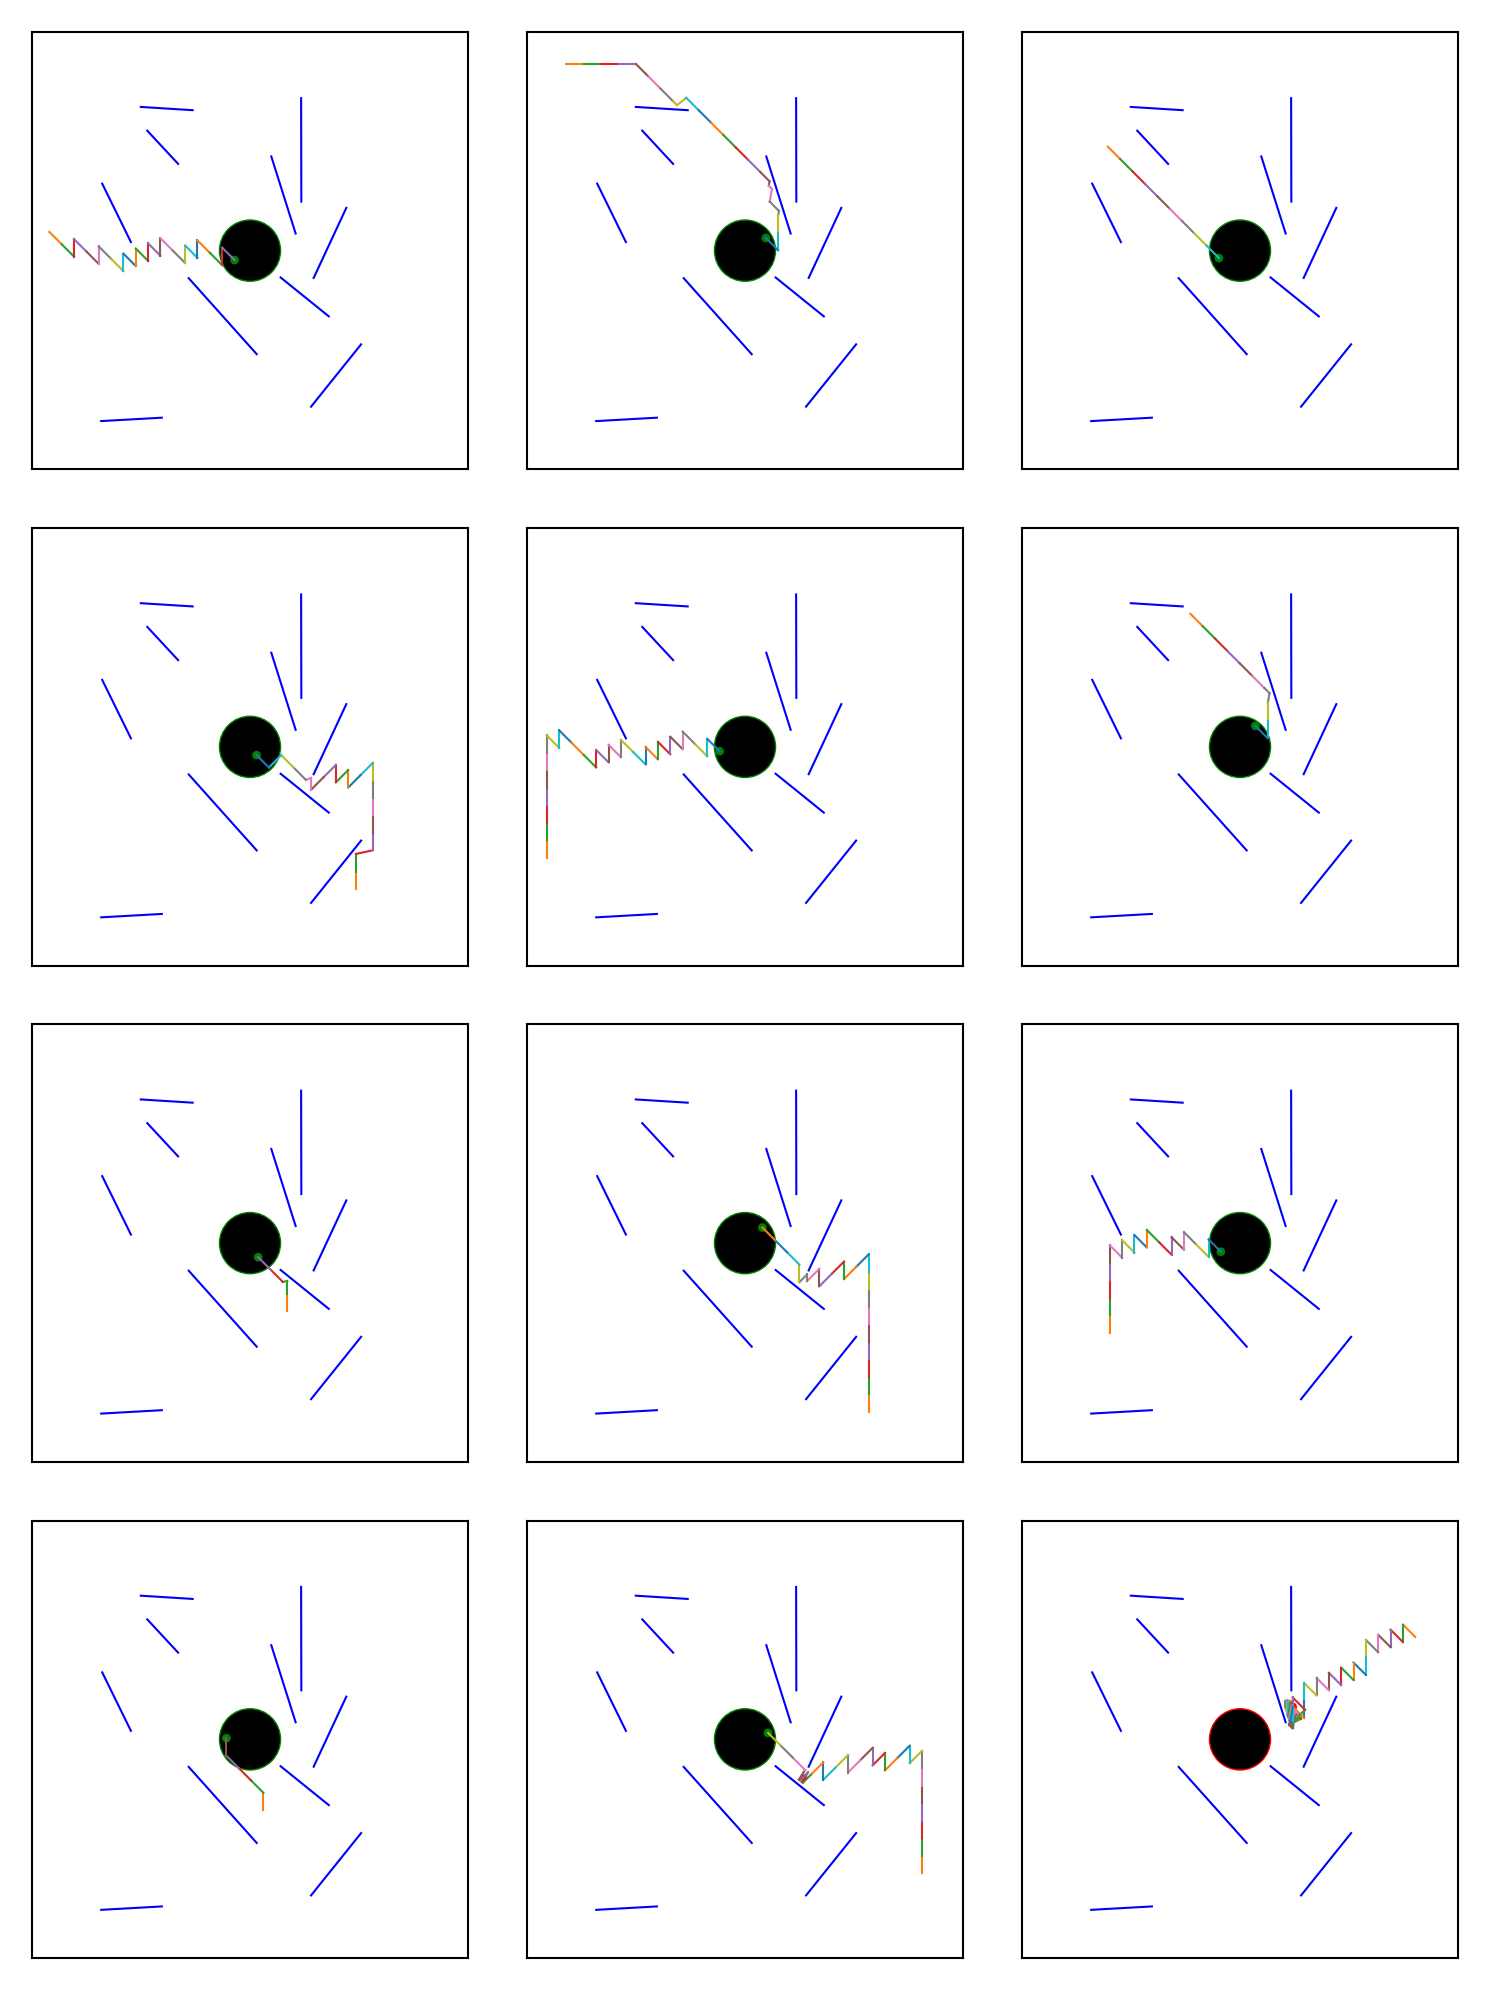

In [8]:
fig, axes = plt.subplots(4, 3, figsize=(15, 20))
axes = axes.flatten()

for i, ax in enumerate(axes):
    ln = get_episode_len(env, q_network, epsilon_greedy)
    print(ln)

    env.render(ax)
    ax.axis('off')

plt.tight_layout()
plt.show()

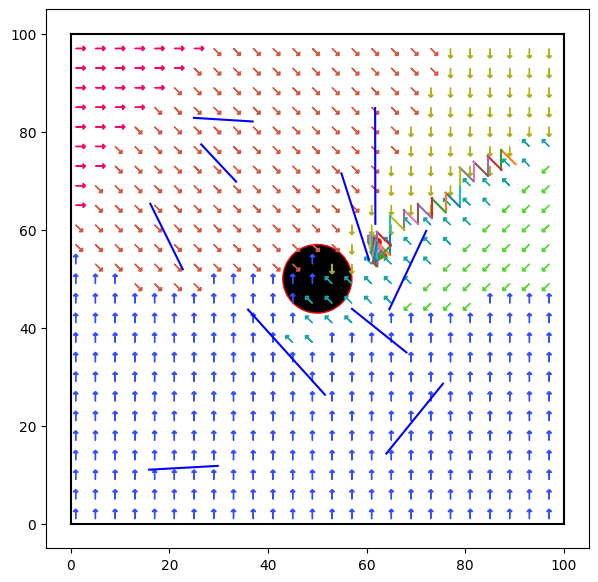

In [9]:
fig, ax = plt.subplots(figsize=(7, 7))

func_for_action = lambda x, y: (q_network(torch.tensor([x, y], dtype=torch.float32)).squeeze().argmax().item() * (360 / 8), 4)

func_for_action(40, 30)
env.render_wind(func_for_action, ax)

## REINFORCE

In [10]:
device = 'cpu'
NUMBER_OF_TRAININGS = 3
reinforce_trains_result_list = [[], [], []]

for train_index in range(NUMBER_OF_TRAININGS):

    # Train the agent
    reinforce_policy_nn, episode_reward_list = train_reinforce_discrete(env=env,
                                                                        num_train_episodes=2000,
                                                                        num_test_per_episode=1,
                                                                        max_episode_duration=101,
                                                                        learning_rate=1e-6)

    reinforce_trains_result_list[0].extend(range(len(episode_reward_list)))
    reinforce_trains_result_list[1].extend(episode_reward_list)
    reinforce_trains_result_list[2].extend([train_index for _ in episode_reward_list])

reinforce_trains_result_df = pd.DataFrame(np.array(reinforce_trains_result_list).T, columns=["num_episodes", "mean_final_episode_reward", "training_index"])
reinforce_trains_result_df["agent"] = "REINFORCE"

# Save the action-value estimation function of the last train

torch.save(reinforce_policy_nn, "reinforce_policy_network.pth")

env.close()

  0%|          | 0/10 [00:00<?, ?it/s]/home/alex/ep/agents/golfRL-project/utils.py:786: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  log_probs = policy_nn(torch.tensor(state, dtype=torch.float32))
/home/alex/ep/agents/golfRL-project/utils.py:760: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = F.log_softmax(out)
100%|██████████| 10/10 [00:25<00:00,  2.52s/it]


100


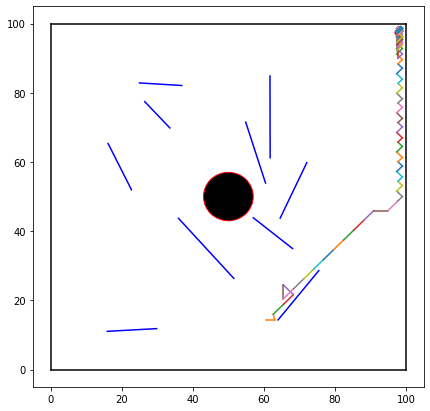

In [12]:
episode_states, episode_actions, episode_rewards, episode_log_prob_actions = sample_one_episode(env, reinforce_policy_nn, max_episode_duration=101)
print(len(episode_states))
env.render()

In [13]:
lens = np.array([len(sample_one_episode(env, reinforce_policy_nn, max_episode_duration=101)[0]) for i in tqdm(range(500))])
print('Mean route len:', np.mean(lens))
print('Success rate:', np.mean(lens < 99))

100%|██████████| 10/10 [00:13<00:00,  1.38s/it]

Mean route len: 100.0
Success rate: 0.0


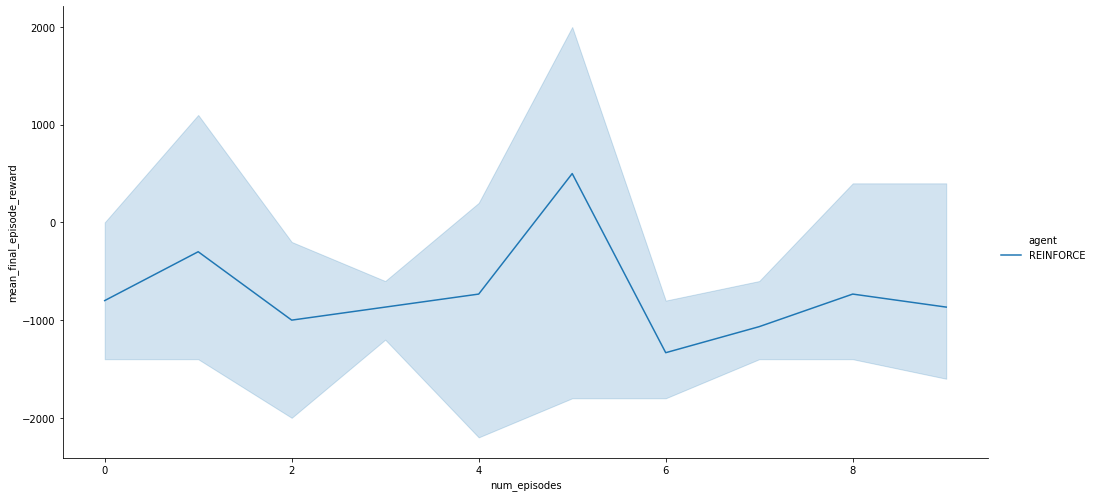

In [14]:
# g = sns.relplot(x="num_episodes", y="mean_final_episode_reward", kind="line", hue="agent", estimator=None, units="training_index", data=dqn2_trains_result_df,
#                 height=7, aspect=2, alpha=0.5);
g = sns.relplot(x="num_episodes", y="mean_final_episode_reward", hue="agent", kind="line", data=reinforce_trains_result_df, height=7, aspect=2)

## A2C

In [29]:
device = 'cpu'
NUMBER_OF_TRAININGS = 3
a2c_trains_result_list = [[], [], []]

for train_index in range(NUMBER_OF_TRAININGS):

    # Train the agent
    a2c_policy_nn, episode_reward_list = train_a2c_discrete(env=env,
                                                            num_train_episodes=2000,
                                                            num_test_per_episode=1,
                                                            max_episode_duration=50,
                                                            learning_rate=4e-3)

    a2c_trains_result_list[0].extend(range(len(episode_reward_list)))
    a2c_trains_result_list[1].extend(episode_reward_list)
    a2c_trains_result_list[2].extend([train_index for _ in episode_reward_list])

a2c_trains_result_df = pd.DataFrame(np.array(reinforce_trains_result_list).T, columns=["num_episodes", "mean_final_episode_reward", "training_index"])
a2c_trains_result_df["agent"] = "A2C"

# Save the action-value estimation function of the last train

torch.save(reinforce_policy_nn, "a2c_policy_network.pth")

env.close()

100%|██████████| 10/10 [00:09<00:00,  1.08it/s]


101


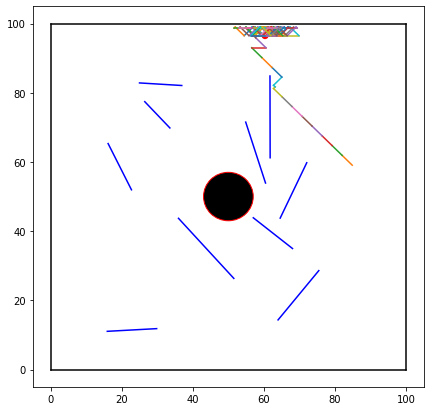

In [30]:
episode_states, _, _, _, _, _ = sample_one_episode_value(env, a2c_policy_nn, max_episode_duration=101)
print(len(episode_states))
env.render()

In [31]:
lens = np.array([len(sample_one_episode_value(env, reinforce_policy_nn, max_episode_duration=101)[0]) for i in tqdm(range(500))])
print('Mean route len:', np.mean(lens))
print('Success rate:', np.mean(lens < 99))

100%|██████████| 10/10 [00:13<00:00,  1.34s/it]

Mean route len: 101.0
Success rate: 0.0


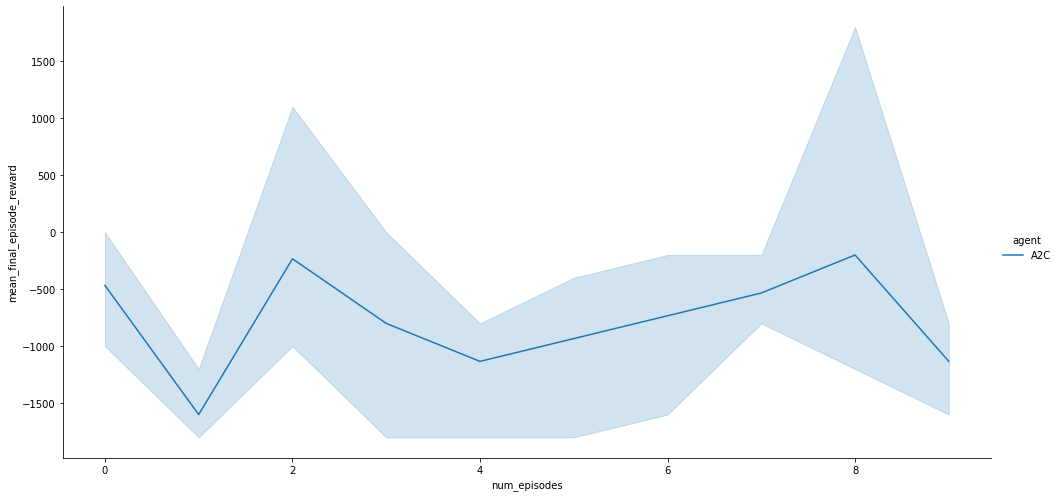

In [32]:
# g = sns.relplot(x="num_episodes", y="mean_final_episode_reward", kind="line", hue="agent", estimator=None, units="training_index", data=dqn2_trains_result_df,
#                 height=7, aspect=2, alpha=0.5);
g = sns.relplot(x="num_episodes", y="mean_final_episode_reward", hue="agent", kind="line", data=reinforce_trains_result_df, height=7, aspect=2)